In [1]:
import os
os.environ['CC'] = 'gcc'
os.environ['CXX'] = 'g++'

import sys
sys.path.append('..')

import jax
import jax.numpy as jnp
import spark
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

# NOTE: Brian throws an error if we don't set a device 
#b2.set_device('cpp_standalone', build_on_run=False)

In [ ]:
def spikes_to_current(spike_times, k=1.0, t_max=100.0, dt=0.1):
    """
    	Convert spike times into a discrete current trace.
    """
    times = np.arange(0, t_max + dt, dt)
    currents = np.zeros_like(times)
    for s in spike_times:
        idx = int(round(s / dt))
        if 0 <= idx < len(currents):
            currents[idx] += k
    return times, currents

def spike_events_to_array(spikes, max_t, dt=0.1):
	times = np.linspace(0, max_t, int(max_t/dt)+1)
	array = np.zeros(times.shape)
	for s in spikes:
		array[int(s / dt)] = 1
	return times, array

@jax.jit
def run_model_split(graph, state, **inputs):
	model = spark.merge(graph, state)
	outputs = model(**inputs)
	_, state = spark.split((model))
	return outputs, state

In [3]:
# This function implement Adaptive Exponential Leaky Integrate-And-Fire neuron model
def simulate_adex_neuron(
        spike_times,
        synapse_strength,
        t_max,
        dt,
        tau_m,
        R,
        v_rest,
        v_reset,
        v_rheobase,
        a,
        b,
        v_spike,
        delta_T,
        tau_w,
    ):
    """
        Simulate a AdEx neuron receiving discrete one-step current inputs from spikes.
    """

    # Reset scope
    b2.start_scope()
    # Build discrete current trace from spikes
    times, currents = spikes_to_current(spike_times, k=synapse_strength, t_max=t_max, dt=dt)
    input_current = b2.TimedArray(currents * b2.nA, dt=dt * b2.ms)
    # Build model
    v_spike_str = "v>{:f}*mvolt".format(v_spike / b2.mvolt)
    eqs = """
        dv/dt = (-(v-v_rest) +delta_T*exp((v-v_rheobase)/delta_T)+ R * input_current(t) - R * w)/(tau_m) : volt
        dw/dt = (a*(v-v_rest)-w)/tau_w : amp
    """
    neuron = b2.NeuronGroup(1, model=eqs, threshold=v_spike_str, reset="v=v_reset;w+=b", method="euler")
    # Initialization
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA
    # Monitors
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)
    # Run simulation
    b2.run(t_max * b2.ms)
    # Get outputs
    times = state_monitor.t / b2.ms
    spikes = [s / b2.ms for s in spike_monitor.t]
    potentials = state_monitor.v[0] / b2.mV
    adaptations = state_monitor.w[0] / b2.pA
    return times, potentials, adaptations, spikes

In [5]:
# Build neuronal model
def build_adex_model(
	dt,
	synapse_strength,
	potential_rest,
	potential_reset,
	potential_tau,
	resistance, # MΩ -> GΩ
	threshold,
	rheobase_threshold,
	spike_slope,
	adaptation_tau,
	adaptation_delta,
	adaptation_subthreshold,	
):
	# NOTE: We need to substract 1 timestep from the cooldown to match the Brian2 dynamic 
	# Since we update the refractory the period at the end of the cycle, Brian2 does it at the begining. 
	adex_neuron = spark.nn.neurons.AdExNeuron(
		_s_units = (1,),
		_s_dt = dt,
		_s_dtype = jnp.float16,
		inhibitory_rate = 0.0,
		soma_config = spark.nn.somas.AdaptiveExponentialSomaConfig(
			potential_rest = potential_rest,
			potential_reset = potential_reset,
			potential_tau = potential_tau,
			resistance = resistance / 1000, # MΩ -> GΩ
			threshold = threshold,
			rheobase_threshold = rheobase_threshold,
			spike_slope = spike_slope,
			adaptation_tau = adaptation_tau,
			adaptation_delta = adaptation_delta,
			adaptation_subthreshold = adaptation_subthreshold,
		),
		synapses_config = spark.nn.synapses.LinearSynapsesConfig(
			units = (1,),
			kernel_initializer = spark.nn.initializers.ConstantInitializerConfig(scale=synapse_strength),
		),
		delays_config = None,
		learning_rule_config = None,
	)
	adex_neuron(in_spikes=spark.SpikeArray( jnp.zeros((1,)) ))
	return adex_neuron

In [4]:
DT = 0.1
MEMBRANE_TIME_SCALE_TAU_M = 5.0
MEMBRANE_RESISTANCE_R = 500.0
V_REST = -70.0
V_RESET = -51.0
RHEOBASE_THRESHOLD_V_RH = -50.0
SHARPNESS_DELTA_T = 2.0
ADAPTATION_VOLTAGE_COUPLING_A = 0.5
ADAPTATION_TIME_CONSTANT_TAU_W = 100.0
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B = 7.0
FIRING_THRESHOLD_V_SPIKE = -30.0
INPUT_SPIKE_TIMES = [10, 20, 30, 32, 34, 36, 38, 55, 60, 62, 70, 84]
SYNAPSE_STRENGTH = 75.0

In [6]:
# Run Brian2 model
b2_times, b2_potentials, b2_adaptations, b2_spikes = simulate_adex_neuron(
	spike_times=INPUT_SPIKE_TIMES,
	synapse_strength=SYNAPSE_STRENGTH,
	t_max=100.0,
	dt=DT,
	tau_m=MEMBRANE_TIME_SCALE_TAU_M * b2.ms,
	R=MEMBRANE_RESISTANCE_R * b2.Mohm,
	v_rest=V_REST * b2.mV,
	v_reset=V_RESET * b2.mV,
	v_rheobase=RHEOBASE_THRESHOLD_V_RH * b2.mV,
	a=ADAPTATION_VOLTAGE_COUPLING_A * b2.nS,
	b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B * b2.pA,
	v_spike=FIRING_THRESHOLD_V_SPIKE * b2.mV,
	delta_T=SHARPNESS_DELTA_T * b2.mV,
	tau_w=ADAPTATION_TIME_CONSTANT_TAU_W * b2.ms,
)

# Run Spark model
adex_neuron = build_adex_model(
	dt = DT,
	synapse_strength = SYNAPSE_STRENGTH,
	potential_rest = V_REST,
	potential_reset = V_RESET,
	potential_tau = MEMBRANE_TIME_SCALE_TAU_M,
	resistance = MEMBRANE_RESISTANCE_R,
	threshold = FIRING_THRESHOLD_V_SPIKE,
	rheobase_threshold = RHEOBASE_THRESHOLD_V_RH,
	spike_slope = SHARPNESS_DELTA_T,
	adaptation_tau = ADAPTATION_TIME_CONSTANT_TAU_W,
	adaptation_delta = SPIKE_TRIGGERED_ADAPTATION_INCREMENT_B ,
	adaptation_subthreshold = ADAPTATION_VOLTAGE_COUPLING_A,	
)
graph, state = spark.split((adex_neuron))
spark_times, in_spikes = spike_events_to_array(INPUT_SPIKE_TIMES, 100, dt=DT)
spark_spikes, spark_potentials, spark_adaptations = [], [], []
for s in in_spikes:
	in_spikes = spark.SpikeArray( jnp.array([s]) )
	outputs, state = run_model_split(graph, state, in_spikes=in_spikes)
	spark_spikes.append(np.array(outputs['out_spikes'].value))
	adex_neuron = spark.merge(graph, state)
	spark_potentials.append(np.array(adex_neuron.soma.potential.value) + V_REST)
	spark_adaptations.append(np.array(adex_neuron.soma.adaptation.value))
spark_spikes = [t*DT for t, s in enumerate(spark_spikes) if s == 1]

/home/nogar/.cython/brian_extensions/_cython_magic_f3e71d279053f2e644b607cdb3f00941.cpp:50:10: fatal error: Python.h: No such file or directory
   50 | #include "Python.h"
      |          ^~~~~~~~~~
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command '/usr/bin/g++' failed with exit code 1 (CompileError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


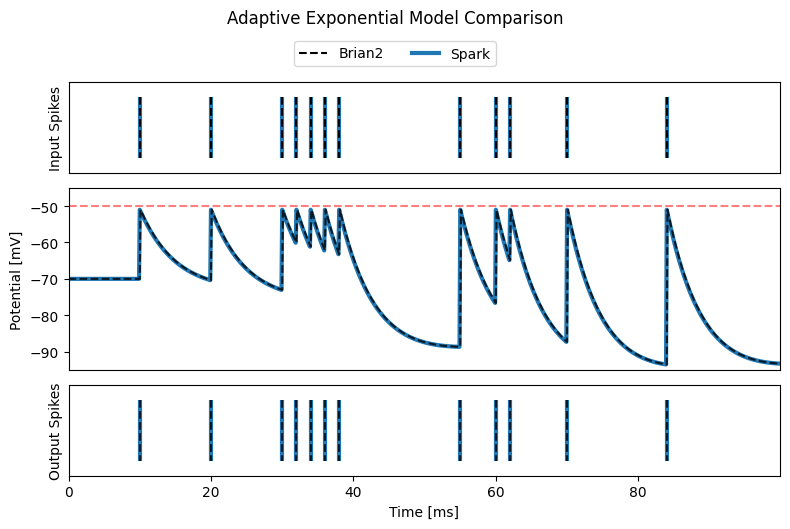

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(8,5), height_ratios=(1,2,1))

ax[0].eventplot(INPUT_SPIKE_TIMES, linewidth=3)
ax[0].eventplot(INPUT_SPIKE_TIMES, color='k', linestyles='--')
ax[0].set_ylabel('Input Spikes')
ax[0].set_ylim(0.25,1.75)
ax[0].set_yticks([], [])
ax[0].set_xticks([], [])

ax[1].plot([0, 100], [RHEOBASE_THRESHOLD_V_RH, RHEOBASE_THRESHOLD_V_RH], 'r--', alpha=0.5)
ax[1].plot(spark_times, spark_potentials, linewidth=3)
ax[1].plot(b2_times, b2_potentials, 'k--', alpha=0.8)
ax[1].set_ylabel('Potential [mV]')
ax[1].set_ylim(-95,-45)
ax[1].set_xticks([], [])

ax[2].eventplot(spark_spikes, linewidths=3)
ax[2].eventplot(b2_spikes, color='k', linestyles='--', alpha=0.8)
ax[2].set_ylabel('Output Spikes')
ax[2].set_yticks([], [])
ax[2].set_ylim(0.25,1.75)
ax[2].set_xlabel('Time [ms]')

for i in range(3):
	#ax[i].set_xlim(0, spark_times[-1])
	ax[i].set_xlim(0, b2_times[-1])

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
	Line2D([], [], color='k', linestyle='--', label='Brian2'), 
	Line2D([], [], linestyle='solid', linewidth=3, label='Spark'), 
]
legend = fig.legend(handles=legend_elements, ncols=2, bbox_to_anchor=(0.5, 1.0), loc='upper center')

plt.suptitle('Adaptive Exponential Model Comparison', y=1.05)
plt.tight_layout()
plt.show()